# STOFS-2D-Global  
Here we are reading, subsetting and visualizing the forecast data from STOFS-2D-Global data. We also read and plot reported water levels at CO-OPS stations. 

In [1]:
import dask
import geoviews as gv
import holoviews as hv
import numcodecs
import numpy as np
import pandas as pd
import shapely
import xarray as xr
import matplotlib.pyplot as plt
import s3fs  # Importing the s3fs library for accessing S3 buckets
import time  # Importing the time library for recording execution time
import shapely  # Importing shapely for geometric operations 
import thalassa  # Importing thalassa library for STOFS data analysis
from thalassa import api  # Importing thalassa API for data handling
from thalassa import normalization
from thalassa import utils
from holoviews import opts as hvopts
from holoviews import streams
from holoviews.streams import PointerXY
from holoviews.streams import Tap
import bokeh.plotting as bp
from datetime import datetime, timedelta, timezone
import searvey

# Read STOFS Data on the Fly

In [2]:
s3 = s3fs.S3FileSystem(anon=True)  # Enable anonymous access to the S3 bucket

bucket_name = 'noaa-gestofs-pds'
key = 'stofs_2d_glo.20240410/stofs_2d_glo.t12z.fields.cwl.nc' # Change this for the date and cycle of your interest.
url = f"s3://{bucket_name}/{key}"
ds = xr.open_dataset(s3.open(url, 'rb'), drop_variables=['nvel'])  # Open NetCDF dataset and drop 'nvel' variable

ds

<xarray.Dataset> Size: 20GB
Dimensions:      (time: 186, node: 12784991, nele: 24875313, nvertex: 3,
                  mesh: 1, nbou: 2530, nvel: 229434)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2024-04-10T07:00:00 ... 2024-04-18
    x            (node) float64 102MB ...
    y            (node) float64 102MB ...
Dimensions without coordinates: node, nele, nvertex, mesh, nbou, nvel
Data variables:
    element      (nele, nvertex) int32 299MB ...
    adcirc_mesh  (mesh) int32 4B ...
    nvell        (nbou) int32 10kB ...
    max_nvell    int32 4B ...
    ibtype       (nbou) int32 10kB ...
    nbvv         (nvel) int32 918kB ...
    depth        (node) float64 102MB ...
    zeta         (time, node) float64 19GB ...
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            0d82f1a
    grid_type:          Triangular
    description:        2024041012 :-6 hr nowcast and +180 hr forecast ! 32 C...
    agrid:              OceanMesh2D
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

# Normalize data using thalassa package

In [3]:
normalized_ds = thalassa.normalize(ds)
normalized_ds

<xarray.Dataset> Size: 20GB
Dimensions:        (time: 186, node: 12784991, face: 24875313,
                    max_no_vertices: 3, mesh: 1, nbou: 2530, nvel: 229434,
                    triface: 24875313, three: 3)
Coordinates:
  * time           (time) datetime64[ns] 1kB 2024-04-10T07:00:00 ... 2024-04-18
    lon            (node) float64 102MB ...
    lat            (node) float64 102MB ...
Dimensions without coordinates: node, face, max_no_vertices, mesh, nbou, nvel,
                                triface, three
Data variables:
    face_nodes     (face, max_no_vertices) int32 299MB 0 2 3 ... 6066314 6076339
    adcirc_mesh    (mesh) int32 4B ...
    nvell          (nbou) int32 10kB ...
    max_nvell      int32 4B ...
    ibtype         (nbou) int32 10kB ...
    nbvv           (nvel) int32 918kB ...
    depth          (node) float64 102MB ...
    zeta           (time, node) float64 19GB ...
    triface_nodes  (triface, three) int32 299MB 0 2 3 ... 6066314 6076339
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            0d82f1a
    grid_type:          Triangular
    description:        2024041012 :-6 hr nowcast and +180 hr forecast ! 32 C...
    agrid:              OceanMesh2D
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

# Crop data Uisng Thalassa Package

In [4]:
# Here we are focusing on the US Northeast region; you can change it to your area of interest.
box = (-74.5, -67, 40, 44)
bbox = shapely.box(box[0], box[2], box[1], box[3])  # Create a shapely box from the bounding box coordinates
subset_ds = thalassa.crop(normalized_ds, bbox)  # Crop the dataset using the bounding box
subset_ds

<xarray.Dataset> Size: 1GB
Dimensions:        (time: 186, node: 464899, face: 24875313,
                    max_no_vertices: 3, mesh: 1, nbou: 2530, nvel: 229434,
                    triface: 909234, three: 3)
Coordinates:
  * time           (time) datetime64[ns] 1kB 2024-04-10T07:00:00 ... 2024-04-18
    lon            (node) float64 4MB -73.68 -73.68 -73.68 ... -67.94 -68.03
    lat            (node) float64 4MB 42.75 42.75 42.75 ... 40.04 40.03 40.02
Dimensions without coordinates: node, face, max_no_vertices, mesh, nbou, nvel,
                                triface, three
Data variables:
    face_nodes     (face, max_no_vertices) int32 299MB 0 2 3 ... 6066314 6076339
    adcirc_mesh    (mesh) int32 4B ...
    nvell          (nbou) int32 10kB ...
    max_nvell      int32 4B ...
    ibtype         (nbou) int32 10kB ...
    nbvv           (nvel) int32 918kB ...
    depth          (node) float64 4MB ...
    zeta           (time, node) float64 692MB ...
    triface_nodes  (triface, three) int32 11MB 0 2 3 1 ... 218042 218043 218058
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            0d82f1a
    grid_type:          Triangular
    description:        2024041012 :-6 hr nowcast and +180 hr forecast ! 32 C...
    agrid:              OceanMesh2D
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

# Plot Data using Thalassa

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
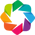

:DynamicMap   []
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [lon,lat]   (lon_lat zeta)

In [6]:
hv.extension("bokeh")
# Set some defaults for the visualization of the graphs
hvopts.defaults(
    hvopts.Image(
        width=800,
        height=600,
        show_title=True,
        tools=["hover"],
        active_tools=["pan", "box_zoom"],
        cmap="jet",
    ),
)

timestamp = pd.Timestamp(subset_ds.time[0].values)

thalassa.plot(
    ds=subset_ds.sel(time=timestamp),  # or `.isel() etc
    variable="zeta", 
    title=f"zeta: {timestamp}",
)



# Find all the CO-OPs stations in the subset area using searvey

In [9]:
station_ds= searvey.coops.coops_product_within_region('water_level', region=bbox, start_date=datetime.fromtimestamp(subset_ds.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(subset_ds.time.values[-1].astype(int) * 1e-9, tz=timezone.utc))
station_ds

<xarray.Dataset> Size: 904kB
Dimensions:  (nos_id: 20, t: 1851)
Coordinates:
  * nos_id   (nos_id) object 160B '8447636' '8518962' ... '8447386' '8454049'
  * t        (t) datetime64[ns] 15kB 2024-04-10T07:00:00 ... 2024-04-18
    nws_id   (nos_id) <U5 400B 'NBFM3' 'TKPN6' 'BRHC3' ... 'FRVM3' 'QPTR1'
    x        (nos_id) float64 160B -70.91 -73.94 -73.18 ... -71.4 -71.16 -71.41
    y        (nos_id) float64 160B 41.62 42.01 41.18 41.28 ... 41.81 41.7 41.59
Data variables:
    v        (nos_id, t) float32 148kB 6.216 6.209 6.203 ... 7.638 7.62 7.614
    s        (nos_id, t) float32 148kB 0.006 0.005 0.006 ... 0.014 0.011 0.011
    f        (nos_id, t) object 296kB '0,0,0,0' '0,0,0,0' ... '0,0,0,0'
    q        (nos_id, t) object 296kB 'v' 'v' 'v' 'v' 'v' ... 'v' 'v' 'v' 'v'

# Plot the stations

In [10]:

variable, timestamp = "zeta", subset_ds.time.values[0]

# The trimesh is the most basic object. This is what you need to create all the others graphs
trimesh = api.create_trimesh(subset_ds.sel(time=timestamp), variable=variable)

# The wireframe is the representation of the mesh
wireframe = api.get_wireframe(trimesh)

# The tiles is using the tiling service from Open Street maps
tiles =  api.get_tiles() 

# The raster object is the basic Map that visualizes the variable. 
raster = api.get_raster(trimesh).opts(width=800, height = 600, cmap="jet", title="zeta")

pins = gv.Points((station_ds['x'],station_ds['y'],station_ds['nos_id']), vdims= "station")
pins = pins.opts(color="red", marker="circle_dot", size=10, tools=["tap", "hover"])

# The pointer/tap timeseries extract the timeseries of a specific node from the xr.Dataset and visualize it.
pointer_dmap = api.get_pointer_timeseries(ds=subset_ds, variable=variable, source_raster=raster)

# Create and customize the zeta timeseries plot
tap_dmap_zeta = api.get_tap_timeseries(ds=subset_ds, variable='zeta', source_raster=raster)
tap_dmap_zeta.opts(
    width=440, height=300, title="water elevation",
    xlabel="Time",  # Use default if units not present
    ylabel="elevation (m)"
)

#raster_layout = tiles * raster * pins + tap_dmap
raster_layout = tiles * raster * pins 
raster_layout

:DynamicMap   []
   :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Image.I  :Image   [lon,lat]   (lon_lat zeta)
      .Points.I :Points   [Longitude,Latitude]   (station)

# Read and save the hourly observation data

In [11]:

# Initialize an empty DataFrame to store the data
Observation = pd.DataFrame()

# Loop over each nos_id
for nos_id in station_ds.nos_id:
   
       # Retrieve water level information for the specified date range
       station= searvey.coops.COOPS_Station(int(nos_id)) 
       station_df = station.product(start_date=datetime.fromtimestamp(subset_ds.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(subset_ds.time.values[-1].astype(int) * 1e-9, tz=timezone.utc), product='water_level',datum='MSL')
      
       # Resample the data to hourly frequency
       hourly_ds = station_df.resample(t='1h').mean() 

       # Add the data for the current station to the result DataFrame
       flattened_values = np.concatenate(hourly_ds['v'].values)
       Observation[int(nos_id)] = flattened_values


Observation

8447636  8518962  8467150  8465705  8447435  8418150  8461490  8510560  \
0    -0.4071   1.2171   0.6800   0.5372   0.9383   0.4609   0.0864   0.0252   
1    -0.4481   1.0551   0.0290  -0.0122   0.5103  -0.5424  -0.1773  -0.1856   
2    -0.3460   0.7716  -0.5294  -0.5238   0.1683  -1.3929  -0.3229  -0.2538   
3    -0.1027   0.5248  -0.9388  -0.9070  -0.0761  -1.7903  -0.2640  -0.1219   
4     0.3011   0.2710  -1.0808  -0.9913  -0.2539  -1.7059  -0.0115   0.1181   
..       ...      ...      ...      ...      ...      ...      ...      ...   
181   0.5138  -0.2485   0.1534   0.1615  -0.4895  -0.1188   0.3806   0.3435   
182   0.4628  -0.1655   0.5073   0.4718  -0.1648   0.4160   0.4592   0.3918   
183   0.2958   0.0377   0.8147   0.7367   0.1359   0.8393   0.5003   0.4044   
184   0.1186   0.2752   0.9798   0.8885   0.3882   1.0440   0.4584   0.3523   
185   0.0320   0.3970   1.0150   0.9200   0.5010   1.0690   0.4210   0.2820   

     8443970  8452944  8531680  8419870  8516945  8518750  8449130  8447930  \
0     0.7547  -0.4434  -0.6304   0.7167   0.9677  -0.5613   0.7059  -0.0068   
1    -0.1629  -0.3878  -0.6091  -0.1535   0.1098  -0.7175   0.4067  -0.1417   
2    -1.1233  -0.3341  -0.3034  -0.9434  -0.6075  -0.5426   0.0567  -0.1954   
3    -1.7699  -0.1252   0.1670  -1.4571  -0.9455  -0.0564  -0.2970  -0.1112   
4    -1.8402   0.2911   0.6429  -1.5084  -1.0605   0.4833  -0.4875   0.0918   
..       ...      ...      ...      ...      ...      ...      ...      ...   
181  -0.1916   0.6061   0.6653  -0.2333   0.0280   0.6245  -0.1470   0.2540   
182   0.3279   0.5385   0.6179   0.2449   0.5228   0.6313  -0.0038   0.2617   
183   0.8146   0.3702   0.4863   0.6415   0.8851   0.5573   0.1539   0.2070   
184   1.0829   0.1481   0.3058   0.8926   1.0390   0.3879   0.2964   0.1521   
185   1.1360   0.0220   0.2010   0.9470   1.0840   0.2730   0.3650   0.1500   

     8452660  8454000  8447386  8454049  
0    -0.3984  -0.4528  -0.4818  -0.4168  
1    -0.3936  -0.3603  -0.3884  -0.4023  
2    -0.2650  -0.3605  -0.3267  -0.2947  
3     0.0148  -0.1583  -0.1524  -0.0441  
4     0.4125   0.2871   0.2426   0.3538  
..       ...      ...      ...      ...  
181   0.5133   0.6413   0.6444   0.5391  
182   0.4490   0.5666   0.5703   0.4803  
183   0.3059   0.4131   0.3783   0.3298  
184   0.1181   0.1764   0.1583   0.1215  
185   0.0170   0.0480   0.0360   0.0320  

[186 rows x 20 columns]

# find the closest nodes to each station

In [12]:
# This step usually takes a few minutes, depending on the region size
subset_ds.load()

<xarray.Dataset> Size: 1GB
Dimensions:        (time: 186, node: 464899, face: 24875313,
                    max_no_vertices: 3, mesh: 1, nbou: 2530, nvel: 229434,
                    triface: 909234, three: 3)
Coordinates:
  * time           (time) datetime64[ns] 1kB 2024-04-10T07:00:00 ... 2024-04-18
    lon            (node) float64 4MB -73.68 -73.68 -73.68 ... -67.94 -68.03
    lat            (node) float64 4MB 42.75 42.75 42.75 ... 40.04 40.03 40.02
Dimensions without coordinates: node, face, max_no_vertices, mesh, nbou, nvel,
                                triface, three
Data variables:
    face_nodes     (face, max_no_vertices) int32 299MB 0 2 3 ... 6066314 6076339
    adcirc_mesh    (mesh) int32 4B -2147483647
    nvell          (nbou) int32 10kB 24 5 9 7 5 9 12 5 5 ... 9 8 13 4 10 4 4 4 6
    max_nvell      int32 4B 24381
    ibtype         (nbou) int32 10kB 24 24 24 24 24 24 24 ... 21 21 21 21 21 21
    nbvv           (nvel) int32 918kB 0 5501371 5482200 5501357 ... 0 0 0 0
    depth          (node) float64 4MB -10.74 -10.74 ... 2.252e+03 2.242e+03
    zeta           (time, node) float64 692MB nan nan nan ... -0.2392 -0.2369
    triface_nodes  (triface, three) int32 11MB 0 2 3 1 ... 218042 218043 218058
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            0d82f1a
    grid_type:          Triangular
    description:        2024041012 :-6 hr nowcast and +180 hr forecast ! 32 C...
    agrid:              OceanMesh2D
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

In [13]:
from typing import List

def  get_indices_of_nearest_nodes(ds: xr.Dataset, lon: float, lat: float, num_nodes: int ) -> List[int]:
    dist = abs(ds.lon - lon) ** 2 + abs(ds.lat - lat) ** 2
    indices_of_nearest_nodes = dist.argsort()[:num_nodes]
    return indices_of_nearest_nodes.values


In [14]:
# Initialize an empty DataFrame to store the data
index = pd.DataFrame()

# Initialize an empty DataFrame to store the data
data = []

# Here we are using the average value of five closest nodes to the station location. 
for nos_id, x, y in zip(station_ds['nos_id'], station_ds['x'], station_ds['y']):
    index_values = get_indices_of_nearest_nodes(subset_ds, x, y,5)
    data.append({'nos_id': nos_id.item() , 'index_value': index_values})

# Convert the list of dictionaries to a DataFrame
index = pd.DataFrame(data)
index 

nos_id                               index_value
0   8447636  [256776, 260521, 256775, 256769, 260516]
1   8518962            [7663, 7676, 7666, 7664, 7678]
2   8467150       [77470, 78576, 78575, 76407, 76406]
3   8465705       [91083, 91087, 89780, 89777, 92399]
4   8447435  [344171, 344170, 340997, 340996, 340998]
5   8418150  [146364, 146358, 146347, 144061, 148748]
6   8461490  [219983, 224018, 224019, 219982, 228112]
7   8510560  [436364, 434197, 438408, 436365, 434195]
8   8443970  [105417, 106894, 105418, 106892, 105414]
9   8452944  [135834, 133701, 133696, 131599, 133700]
10  8531680  [382201, 382202, 379159, 379160, 379158]
11  8419870  [134434, 136557, 136558, 134438, 134427]
12  8516945       [26143, 26146, 26142, 25749, 26539]
13  8518750  [154048, 156506, 156509, 154042, 154046]
14  8449130  [390061, 390069, 392933, 390053, 392934]
15  8447930  [248677, 248676, 252644, 248675, 252640]
16  8452660  [303696, 306590, 306657, 306660, 303697]
17  8454000       [70507, 71387, 69637, 70504, 71385]
18  8447386  [111091, 111082, 112661, 112670, 109558]
19  8454049  [244246, 240175, 240173, 244248, 244245]

In [15]:
# Initialize an empty DataFrame to store the data
Forecast = pd.DataFrame()
# Loop over each nos_id
for nos_id in station_ds.nos_id:
   
       # Add the foreact data for the current station to the result DataFrame
       subset_values = subset_ds['zeta'].isel(node=index.index_value[index['nos_id'] == nos_id].values[0])
       flattened_values = np.nanmean(subset_values, axis=1)
       Forecast[int(nos_id)] = flattened_values

# Display the resulting DataFrame
Forecast

8447636   8518962   8467150   8465705   8447435   8418150   8461490  \
0   -0.528844  0.820428  0.472550  0.343797  0.939116  0.619432 -0.166643   
1   -0.556716  0.654064 -0.124579 -0.172595  0.429831 -0.318499 -0.434119   
2   -0.536173  0.359496 -0.656784 -0.655290 -0.035202 -1.164377 -0.574666   
3   -0.303977  0.126876 -1.065426 -1.049833 -0.377156 -1.782064 -0.481886   
4    0.126842 -0.051593 -1.229373 -1.128460 -0.560026 -1.886474 -0.198262   
..        ...       ...       ...       ...       ...       ...       ...   
181  0.245444 -0.391949 -0.353601 -0.285802 -0.636078 -0.510135  0.038887   
182  0.234131 -0.408414  0.067499  0.076535 -0.347719  0.005203  0.177073   
183  0.183799 -0.247571  0.456575  0.402664 -0.008335  0.467421  0.281190   
184  0.074178 -0.002452  0.742686  0.676280  0.307967  0.791171  0.288604   
185 -0.089264  0.187677  0.847685  0.766216  0.538297  0.907844  0.215992   

      8510560   8443970   8452944   8531680   8419870   8516945   8518750  \
0   -0.197796  0.893301 -0.606543 -0.858266  0.895293  0.720605 -0.698727   
1   -0.431224  0.035203 -0.520271 -0.889836  0.036412 -0.072422 -0.877373   
2   -0.508230 -0.961545 -0.521681 -0.633310 -0.757646 -0.708579 -0.757651   
3   -0.396967 -1.710249 -0.341429 -0.170512 -1.347851 -1.077584 -0.319957   
4   -0.153603 -1.896911  0.055120  0.301427 -1.690520 -1.214200  0.160565   
..        ...       ...       ...       ...       ...       ...       ...   
181 -0.039024 -0.592505  0.365209  0.338999 -0.585358 -0.612707  0.273398   
182  0.065930 -0.094154  0.288489  0.309911 -0.123981  0.023593  0.326671   
183  0.144448  0.421448  0.177605  0.172237  0.266457  0.532759  0.262376   
184  0.138460  0.734238  0.075986 -0.019710  0.577420  0.754745  0.103440   
185  0.098747  0.926821 -0.071746 -0.211749  0.770229  0.812551 -0.123492   

      8449130   8447930   8452660   8454000   8447386   8454049  
0    0.566289 -0.199383 -0.567457 -0.634801 -0.603624 -0.550763  
1    0.313585 -0.327330 -0.562241 -0.441805 -0.509776 -0.543856  
2   -0.065071 -0.353262 -0.443244 -0.539437 -0.510825 -0.454077  
3   -0.444676 -0.271414 -0.204488 -0.350025 -0.345124 -0.254856  
4   -0.716192 -0.073383  0.177588  0.032613  0.057764  0.140864  
..        ...       ...       ...       ...       ...       ...  
181 -0.429859  0.001083  0.272119  0.429098  0.382064  0.318064  
182 -0.260515  0.049933  0.256989  0.303610  0.296379  0.292522  
183 -0.087307  0.055309  0.170404  0.207154  0.177471  0.197620  
184  0.081337  0.017768  0.041437  0.103669  0.095847  0.071023  
185  0.247432 -0.040581 -0.106540 -0.037588 -0.058675 -0.072230  

[186 rows x 20 columns]

# Plot the timeseries on the time of the map 

In [16]:
obs_zeta = np.full((len(subset_ds.time), len(subset_ds.node)), np.nan)
mod_zeta = subset_ds['zeta'].values

for nos_id, x, y in zip(station_ds['nos_id'], station_ds['x'], station_ds['y']):
    index_values = get_indices_of_nearest_nodes(subset_ds, x, y, 1500)
    for index in index_values:
         obs_zeta[:, index] =  Observation[int(nos_id)]
         mod_zeta[:, index] =  Forecast[int(nos_id)]

# Calculate max water level across each node,
subset_ds['zeta_max'] = subset_ds['zeta'].max(axis=0)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
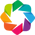

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Overlay
         .WMTS.I   :WMTS   [Longitude,Latitude]
         .Image.I  :Image   [lon,lat]   (lon_lat zeta_max)
         .Points.I :Points   [Longitude,Latitude]   (station)
   .DynamicMap.II :DynamicMap   []
      :Overlay
         .Curve.I  :Curve   [x]   (y)
         .Curve.II :Curve   [x]   (y)

In [17]:
hv.extension("bokeh")

variable, timestamp = "zeta_max", subset_ds.time.values[0]

# The trimesh is the most basic object. This is what you need to create all the others graphs
trimesh = api.create_trimesh(subset_ds.sel(time=timestamp), variable=variable)

# The wireframe is the representation of the mesh
wireframe = api.get_wireframe(trimesh)

# The tiles is using the tiling service from Open Street maps
tiles =  api.get_tiles() 


# Convert the NumPy array to an xarray DataArray
subset_ds['obs_zeta'] = subset_ds['zeta']
subset_ds['mod_zeta'] = subset_ds['zeta']

# Add the new variable to the dataset
subset_ds['obs_zeta'].values = obs_zeta
subset_ds['mod_zeta'].values = mod_zeta


# The raster object is the basic Map that visualizes the variable. 
raster = api.get_raster(trimesh).opts(width=800, height = 600, cmap="jet", title="zeta_max")

pins = gv.Points((station_ds['x'],station_ds['y'],station_ds['nos_id']), vdims= "station")
pins = pins.opts(color="red", marker="circle_dot", size=10, tools=["tap", "hover"])

# Create and customize the zeta timeseries plot
tap_dmap_zeta = api.get_tap_timeseries(ds=subset_ds, variable='mod_zeta', source_raster=raster)
tap_dmap_zeta.opts(
    width=440, height=300, title="water elevation",
    xlabel="Time",  # Use default if units not present
    ylabel="Elevation (m)",
    color='blue'  # Set color to blue

)

tap_dmap_obs_zeta = api.get_tap_timeseries(ds=subset_ds, variable='obs_zeta', source_raster=raster)
tap_dmap_obs_zeta.opts(
    width=440, height=300, title="water elevation",
    xlabel="Time",  # Use default if units not present
    ylabel="Elevation (m)",
    color='red'  # Set color to red
)

# Create a legend

overlay_plot = tap_dmap_zeta * tap_dmap_obs_zeta


#raster_layout = tiles * raster * pins + tap_dmap
raster_layout = tiles * raster * pins + overlay_plot.opts()

raster_layout